<a href="https://colab.research.google.com/github/ZaichenkoNA/Stat_Prac/blob/main/Proekt.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [106]:
import pandas as pd
from google.colab import drive
drive.mount('/content/drive')
credits_df = pd.read_csv("./drive/MyDrive/credits.csv", low_memory=False)
titles_df = pd.read_csv("./drive/MyDrive/titles.csv", low_memory=False)

print(credits_df.head())
print(titles_df.head())



Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
   person_id       id             name                character   role
0       3748  tm84618   Robert De Niro            Travis Bickle  ACTOR
1      14658  tm84618     Jodie Foster            Iris Steensma  ACTOR
2       7064  tm84618    Albert Brooks                      Tom  ACTOR
3       3739  tm84618    Harvey Keitel  Matthew 'Sport' Higgins  ACTOR
4      48933  tm84618  Cybill Shepherd                    Betsy  ACTOR
         id                                title   type  \
0  ts300399  Five Came Back: The Reference Films   SHOW   
1   tm84618                          Taxi Driver  MOVIE   
2  tm154986                          Deliverance  MOVIE   
3  tm127384      Monty Python and the Holy Grail  MOVIE   
4  tm120801                      The Dirty Dozen  MOVIE   

                                         description  release_year  \
0  This collection i

In [50]:
print(credits_df.info())
print(titles_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 77801 entries, 0 to 77800
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   person_id  77801 non-null  int64 
 1   id         77801 non-null  object
 2   name       77801 non-null  object
 3   character  68029 non-null  object
 4   role       77801 non-null  object
dtypes: int64(1), object(4)
memory usage: 3.0+ MB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5850 entries, 0 to 5849
Data columns (total 15 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   id                    5850 non-null   object 
 1   title                 5849 non-null   object 
 2   type                  5850 non-null   object 
 3   description           5832 non-null   object 
 4   release_year          5850 non-null   int64  
 5   age_certification     3231 non-null   object 
 6   runtime               5850 non-null   int64 

In [51]:

print(titles_df.describe())

       release_year      runtime      seasons   imdb_score    imdb_votes  \
count   5850.000000  5850.000000  2106.000000  5368.000000  5.352000e+03   
mean    2016.417094    76.888889     2.162868     6.510861  2.343938e+04   
std        6.937726    39.002509     2.689041     1.163826  9.582047e+04   
min     1945.000000     0.000000     1.000000     1.500000  5.000000e+00   
25%     2016.000000    44.000000     1.000000     5.800000  5.167500e+02   
50%     2018.000000    83.000000     1.000000     6.600000  2.233500e+03   
75%     2020.000000   104.000000     2.000000     7.300000  9.494000e+03   
max     2022.000000   240.000000    42.000000     9.600000  2.294231e+06   

       tmdb_popularity   tmdb_score  
count      5759.000000  5539.000000  
mean         22.637925     6.829175  
std          81.680263     1.170391  
min           0.009442     0.500000  
25%           2.728500     6.100000  
50%           6.821000     6.900000  
75%          16.590000     7.537500  
max        

Проверим отсутствующие данные:

In [52]:
credits_df.isna().sum()


,0
person_id,0
id,0
name,0
character,9772
role,0


In [53]:
titles_df.isna().sum()

,0
id,0
title,1
type,0
description,18
release_year,0
age_certification,2619
runtime,0
genres,0
production_countries,0
seasons,3744


Обработка данных:

In [107]:
import pandas as pd

# Разделяем актеров и режиссеров
actors_df = credits_df[credits_df['role'] == 'ACTOR'].copy()
directors_df = credits_df[credits_df['role'] == 'DIRECTOR'].copy()

# 1. Фичи для актеров
# Популярность актеров (по количеству фильмов)
actor_counts = actors_df["name"].value_counts()
actors_df["actor_popularity"] = actors_df["name"].map(actor_counts)

# Средняя популярность актеров в фильме
actor_popularity_per_movie = actors_df.groupby("id")["actor_popularity"].mean().reset_index()
actor_popularity_per_movie.rename(columns={"actor_popularity": "avg_actor_popularity"}, inplace=True)

# Количество актеров в фильме
actor_count_per_movie = actors_df.groupby("id")["person_id"].count().reset_index()
actor_count_per_movie.rename(columns={"person_id": "num_actors"}, inplace=True)

# Наличие топ-актера в фильме
top_100_actors = set(actor_counts.head(100).index)
actors_df["has_top_actor"] = actors_df["name"].isin(top_100_actors)
top_actor_flag_per_movie = actors_df.groupby("id")["has_top_actor"].max().reset_index()

# 3. Объединяем все фичи с основной таблицей
titles_df = titles_df.merge(actor_popularity_per_movie, on="id", how="left")
titles_df = titles_df.merge(actor_count_per_movie, on="id", how="left")
titles_df = titles_df.merge(top_actor_flag_per_movie, on="id", how="left")




Обработаем пропуски:

In [108]:
titles_df["avg_actor_popularity"] = titles_df["avg_actor_popularity"].fillna(0)
titles_df["num_actors"] = titles_df["num_actors"].fillna(0)
titles_df["has_top_actor"] = titles_df["has_top_actor"].fillna(False)
titles_df["runtime"] = titles_df["runtime"].fillna(titles_df["runtime"].median())
titles_df["tmdb_popularity"] = titles_df["tmdb_popularity"].fillna(0)
titles_df["imdb_votes"] = titles_df["imdb_votes"].fillna(0)


<ipython-input-108-54d65b6f67ec>:3: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  titles_df["has_top_actor"] = titles_df["has_top_actor"].fillna(False)


In [109]:
# Обработка жанров (one-hot encoding)
genres_exploded = titles_df["genres"].str.strip("[]").str.replace("'", "").str.split(", ")
unique_genres = set(
    genre
    for sublist in genres_exploded.dropna()
    for genre in sublist
    if genre.strip()  # Игнорируем пустые строки ("")
)

# Создаём бинарные столбцы только для непустых жанров
genre_df = pd.DataFrame({
    f"genre_{genre}": genres_exploded.apply(lambda x: genre in x if isinstance(x, list) else False)
    for genre in unique_genres
})
titles_df = pd.concat([titles_df, genre_df], axis=1)


In [110]:
# Обработка стран (one-hot encoding)
countries_exploded = titles_df["production_countries"].str.strip("[]").str.replace("'", "").str.split(", ")
unique_countries = set(
    country
    for sublist in countries_exploded.dropna()
    for country in sublist
    if country.strip()  # Игнорируем пустые строки ("")
)
country_df = pd.DataFrame({
    f"country_{country}": countries_exploded.apply(lambda x: country in x if isinstance(x, list) else False)
    for country in unique_countries
})
titles_df = pd.concat([titles_df, country_df], axis=1)

titles_df = titles_df.dropna(subset=["imdb_score"])
print("Предобработка завершена!")

Предобработка завершена!


Найдём распределения:

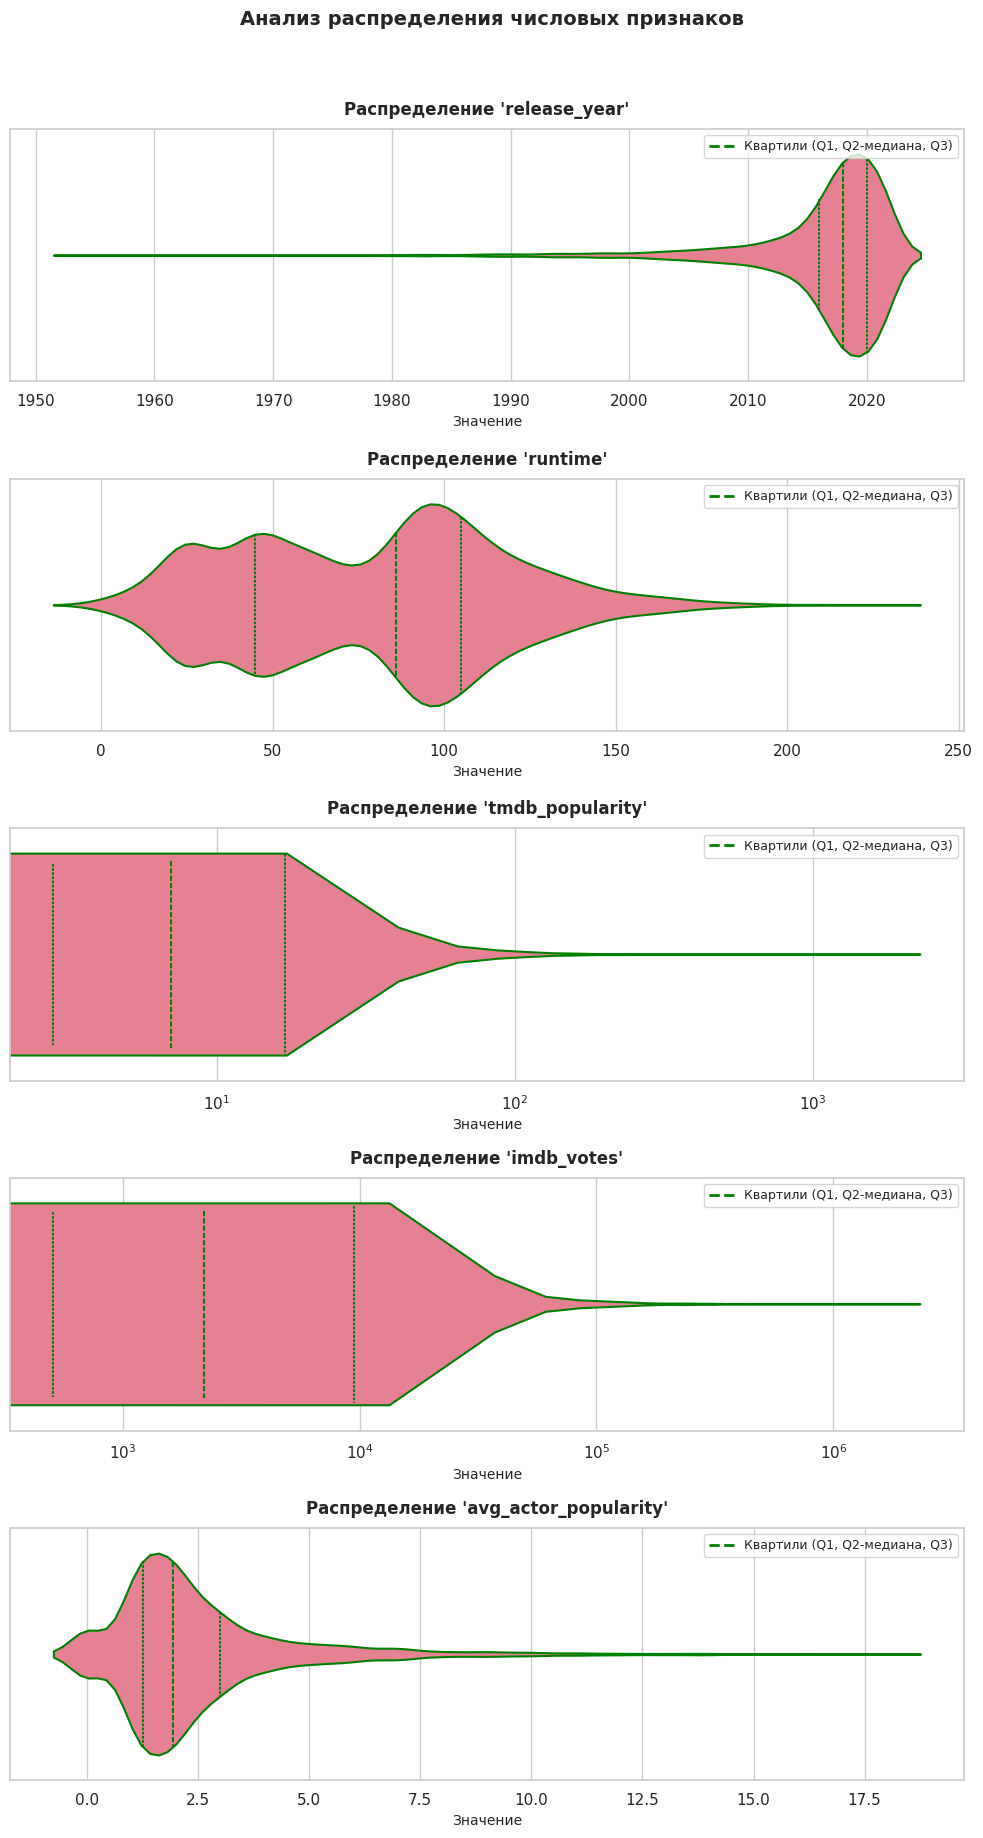

In [111]:
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D  # Для создания кастомных элементов легенды

sns.set_theme(style="whitegrid", palette="husl")
numeric_features = ["release_year", "runtime", "tmdb_popularity", "imdb_votes", "avg_actor_popularity"]
fig, axes = plt.subplots(len(numeric_features), 1, figsize=(10, 18), dpi=100)

for i, feature in enumerate(numeric_features):
    ax = axes[i]
    sns.violinplot(
        x=titles_df[feature],
        ax=ax,
        inner="quartile",
        linewidth=1.5,
        linecolor="green",
    )

    ax.set_title(f"Распределение '{feature}'", fontsize=12, pad=10, fontweight="bold")
    ax.set_xlabel("Значение", fontsize=10)

    # Логарифмическая шкала для некоторых признаков
    if feature in ["imdb_votes", "tmdb_popularity"]:
        ax.set_xscale("log")

    legend_elements = [
        Line2D([0], [0], color='green', linestyle='--', lw=2,
               label='Квартили (Q1, Q2-медиана, Q3)'),
    ]
    ax.legend(handles=legend_elements, loc='upper right', fontsize=9)

plt.suptitle("Анализ распределения числовых признаков", fontsize=14, y=1.02, fontweight="bold")
plt.tight_layout()
plt.show()

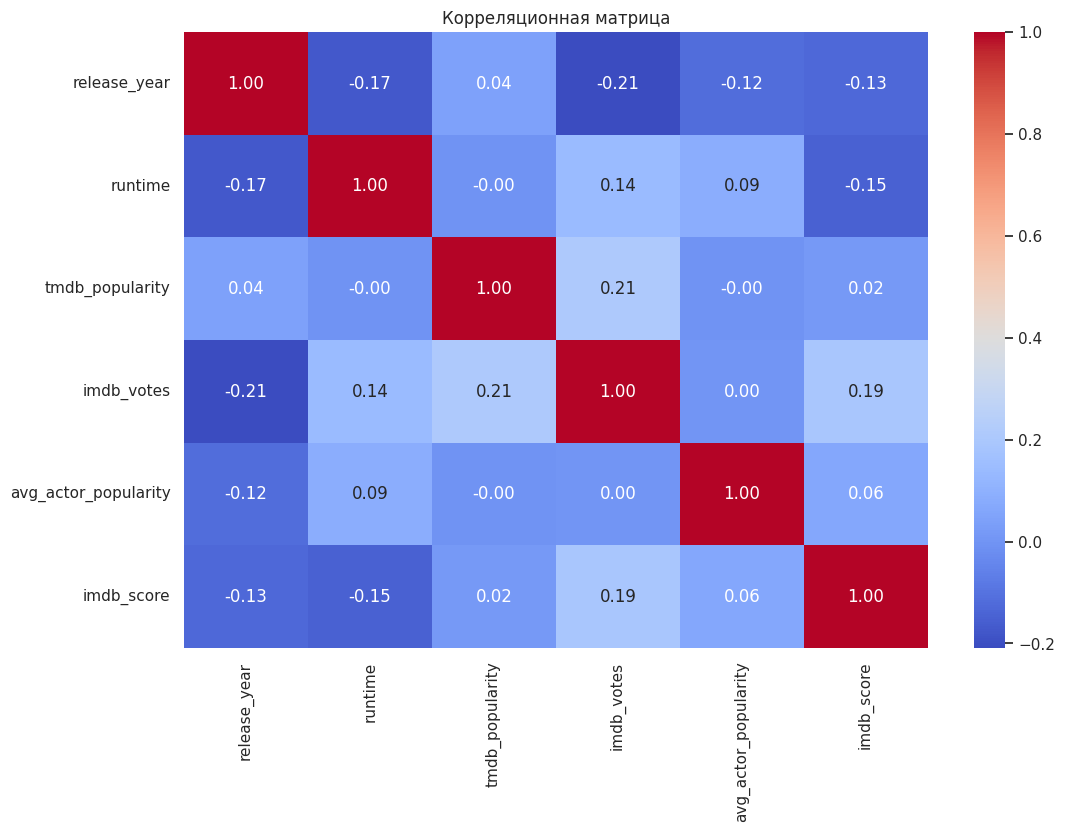

In [112]:
# Корреляционная матрица
corr_matrix = titles_df[numeric_features + ["imdb_score"]].corr()
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Корреляционная матрица")
plt.show()

Посмотрим на рейтинг по странам:

<ipython-input-113-b214b912e0ac>:37: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(


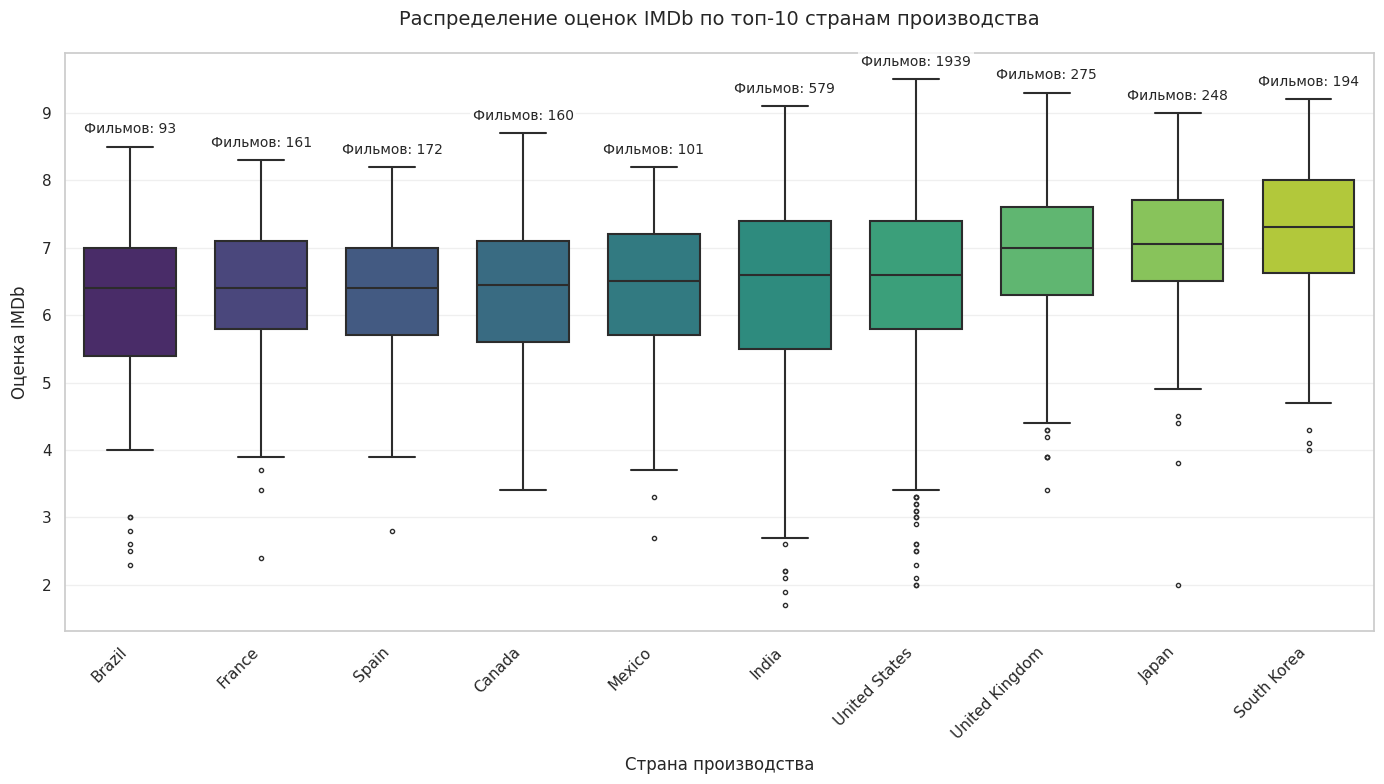

In [113]:
!pip install pycountry
import pycountry

sns.set_style("whitegrid")
plt.rcParams['figure.facecolor'] = 'white'

# Функция для преобразования кодов стран в полные названия
def extract_and_convert_country(raw_str):
    if not isinstance(raw_str, str):  # Проверяем, что это строка
        return None
    cleaned = raw_str.strip("[]").replace("'", "").replace("\"", "").strip()
    if not cleaned:
        return None
    codes = [code.strip() for code in cleaned.split(",") if code.strip()]
    if not codes:
        return None
    code = codes[0]
    country = pycountry.countries.get(alpha_2=code.upper())
    return country.name if country else None

titles_df["production_countries_full"] = titles_df["production_countries"].apply(extract_and_convert_country)

valid_titles = titles_df[titles_df["production_countries_full"].notnull()]
filtered_titles = valid_titles.copy()
# Заменяем название Южной Кореи на более короткое
filtered_titles["production_countries_full"] = filtered_titles["production_countries_full"].replace(
    "Korea, Republic of", "South Korea")

# Выбираем топ-10 стран по количеству фильмов
top_countries = filtered_titles["production_countries_full"].value_counts().head(10).index
filtered_df = filtered_titles[filtered_titles["production_countries_full"].isin(top_countries)]

# Сортируем страны по медианному значению IMDb
country_order = filtered_df.groupby("production_countries_full")["imdb_score"].median().sort_values().index

plt.figure(figsize=(14, 8))
ax = sns.boxplot(
    x="production_countries_full",
    y="imdb_score",
    data=filtered_df,
    order=country_order,
    palette="viridis",
    width=0.7,
    linewidth=1.5,
    fliersize=3
)

plt.xticks(rotation=45, ha='right', fontsize=11)
plt.yticks(fontsize=11)
plt.xlabel("Страна производства", fontsize=12, labelpad=10)
plt.ylabel("Оценка IMDb", fontsize=12, labelpad=10)
plt.title("Распределение оценок IMDb по топ-10 странам производства", fontsize=14, pad=20)

# Добавляем аннотации с количеством фильмов
counts = filtered_df["production_countries_full"].value_counts().loc[country_order]
max_scores = filtered_df.groupby("production_countries_full")["imdb_score"].max().loc[country_order]

for i, country in enumerate(country_order):
    count = counts[country]
    y_pos = max_scores[country] + 0.15
    ax.text(
        i, y_pos, f"Фильмов: {count}",
        ha='center',
        va='bottom',
        fontsize=10,
        bbox=dict(facecolor='white', alpha=0.8, edgecolor='none', pad=2)
    )

plt.grid(axis='y', alpha=0.3)
plt.tight_layout()

plt.show()

Посмотрим на рейтинг по актёрам:

<ipython-input-114-1e437b9cc6f7>:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(


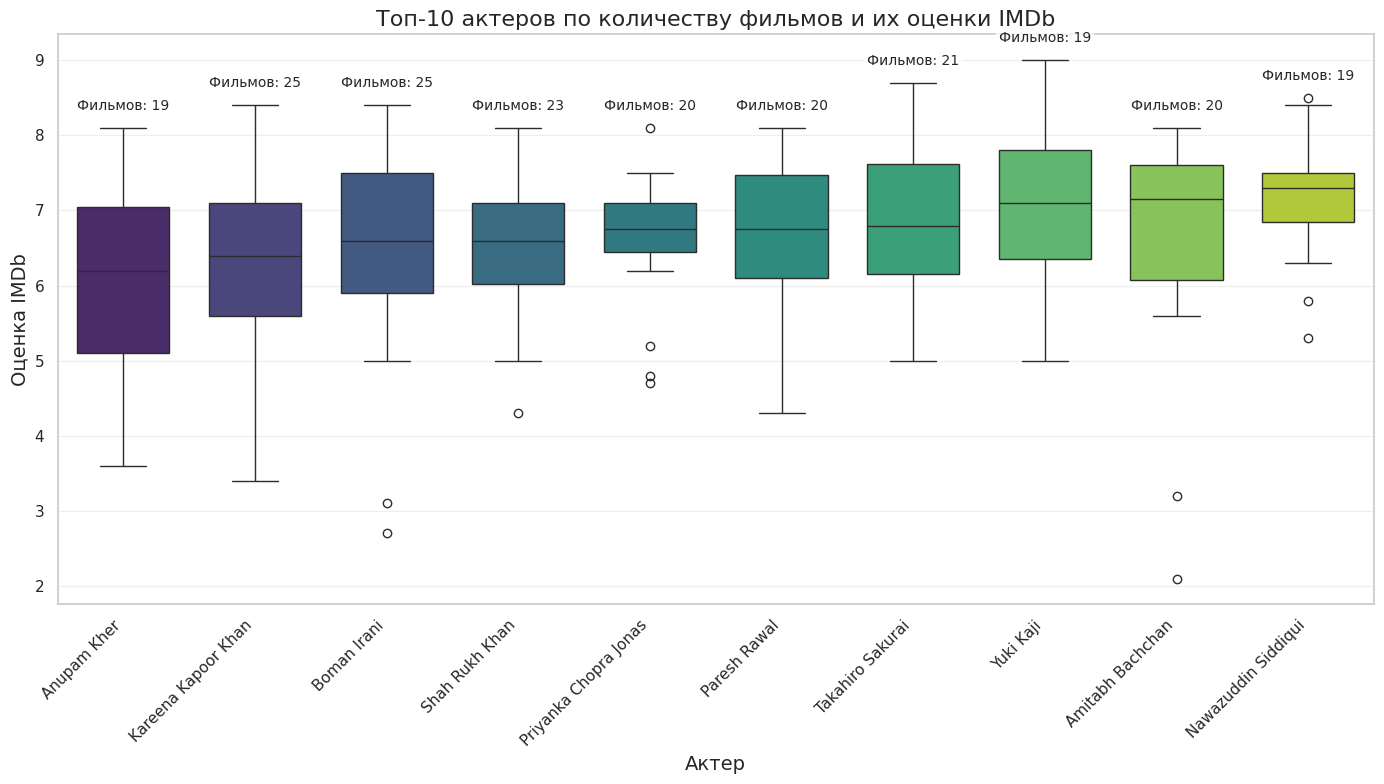

In [114]:
# Получаем топ-10 актеров по количеству фильмов
top_actors = credits_df[credits_df['role'] == 'ACTOR']['name'].value_counts().head(10)
top_actor_names = top_actors.index

# Фильтруем только фильмы с этими актерами
actor_movies = credits_df[(credits_df['name'].isin(top_actor_names)) & (credits_df['role'] == 'ACTOR')]

# Объединяем с оценками IMDb
actor_scores = pd.merge(actor_movies[['id', 'name']],
                       titles_df[['id', 'imdb_score']],
                       on='id')

# Сортируем по медианной оценке
actor_order = actor_scores.groupby('name')['imdb_score'].median().sort_values().index

# Строим boxplot
plt.figure(figsize=(14, 8))
ax = sns.boxplot(
    x='name',
    y='imdb_score',
    data=actor_scores,
    order=actor_order,
    palette="viridis",
    width=0.7
)

# Добавляем подписи с количеством фильмов
for i, actor in enumerate(actor_order):
    count = top_actors[actor]
    ax.text(i,
            actor_scores[actor_scores['name'] == actor]['imdb_score'].max() + 0.2,
            f'Фильмов: {count}',
            ha='center',
            va='bottom',
            fontsize=10,
            bbox=dict(facecolor='white', alpha=0.8, edgecolor='none', pad=2))

plt.title('Топ-10 актеров по количеству фильмов и их оценки IMDb', fontsize=16)
plt.xlabel('Актер', fontsize=14)
plt.ylabel('Оценка IMDb', fontsize=14)
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

<ipython-input-115-54b09dc92f4a>:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(


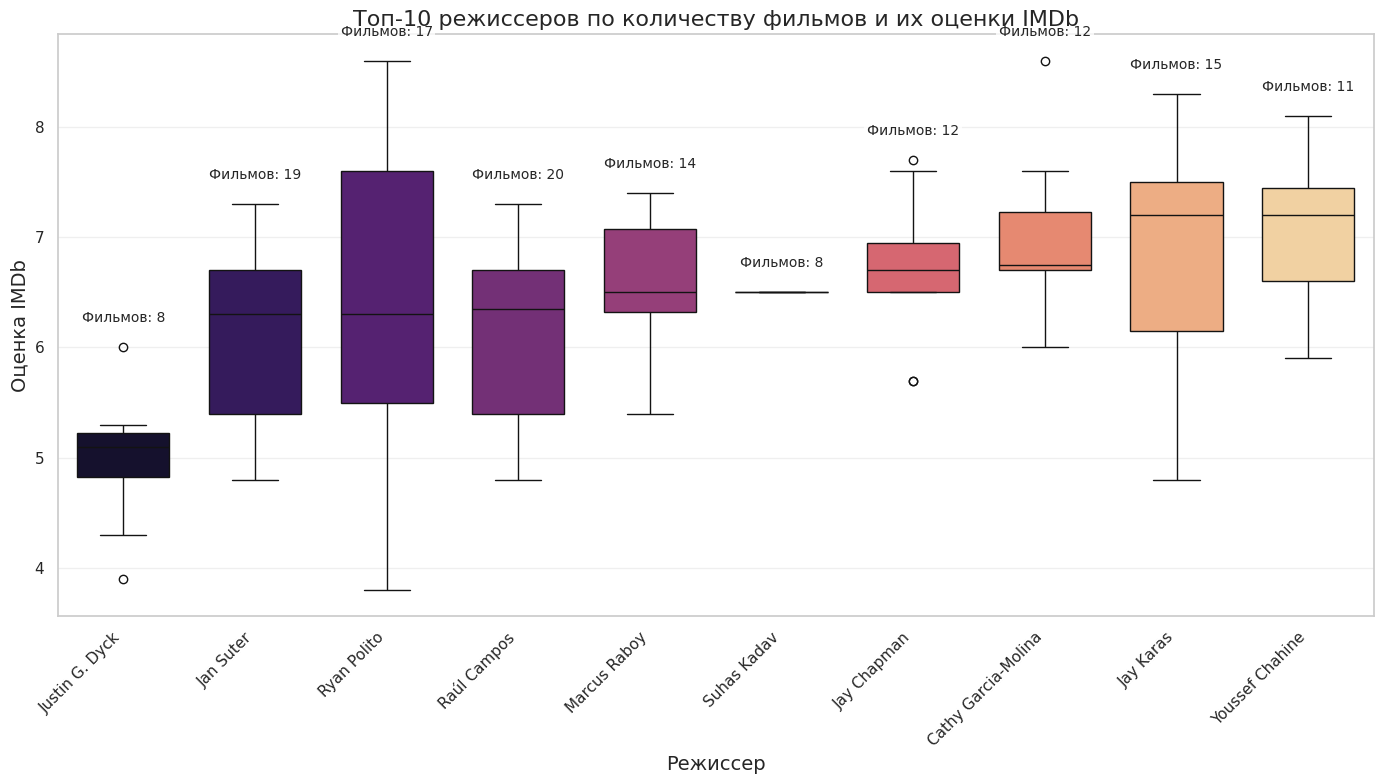

In [115]:
# Получаем топ-10 режиссеров по количеству фильмов
top_directors = credits_df[credits_df['role'] == 'DIRECTOR']['name'].value_counts().head(10)
top_director_names = top_directors.index

# Фильтруем только фильмы с этими режиссерами
director_movies = credits_df[(credits_df['name'].isin(top_director_names)) & (credits_df['role'] == 'DIRECTOR')]

# Объединяем с оценками IMDb
director_scores = pd.merge(director_movies[['id', 'name']],
                          titles_df[['id', 'imdb_score']],
                          on='id')

# Сортируем по медианной оценке
director_order = director_scores.groupby('name')['imdb_score'].median().sort_values().index

# Строим boxplot
plt.figure(figsize=(14, 8))
ax = sns.boxplot(
    x='name',
    y='imdb_score',
    data=director_scores,
    order=director_order,
    palette="magma",
    width=0.7
)

# Добавляем подписи с количеством фильмов
for i, director in enumerate(director_order):
    count = top_directors[director]
    ax.text(i,
            director_scores[director_scores['name'] == director]['imdb_score'].max() + 0.2,
            f'Фильмов: {count}',
            ha='center',
            va='bottom',
            fontsize=10,
            bbox=dict(facecolor='white', alpha=0.8, edgecolor='none', pad=2))

plt.title('Топ-10 режиссеров по количеству фильмов и их оценки IMDb', fontsize=16)
plt.xlabel('Режиссер', fontsize=14)
plt.ylabel('Оценка IMDb', fontsize=14)
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

Посмотрим на жанры:

<ipython-input-117-1ad222f99c3d>:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=genre_counts.head(15).values, y=genre_counts.head(15).index, palette='viridis')
<ipython-input-117-1ad222f99c3d>:30: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=genre_scores.head(15).values, y=genre_scores.head(15).index, palette='rocket')


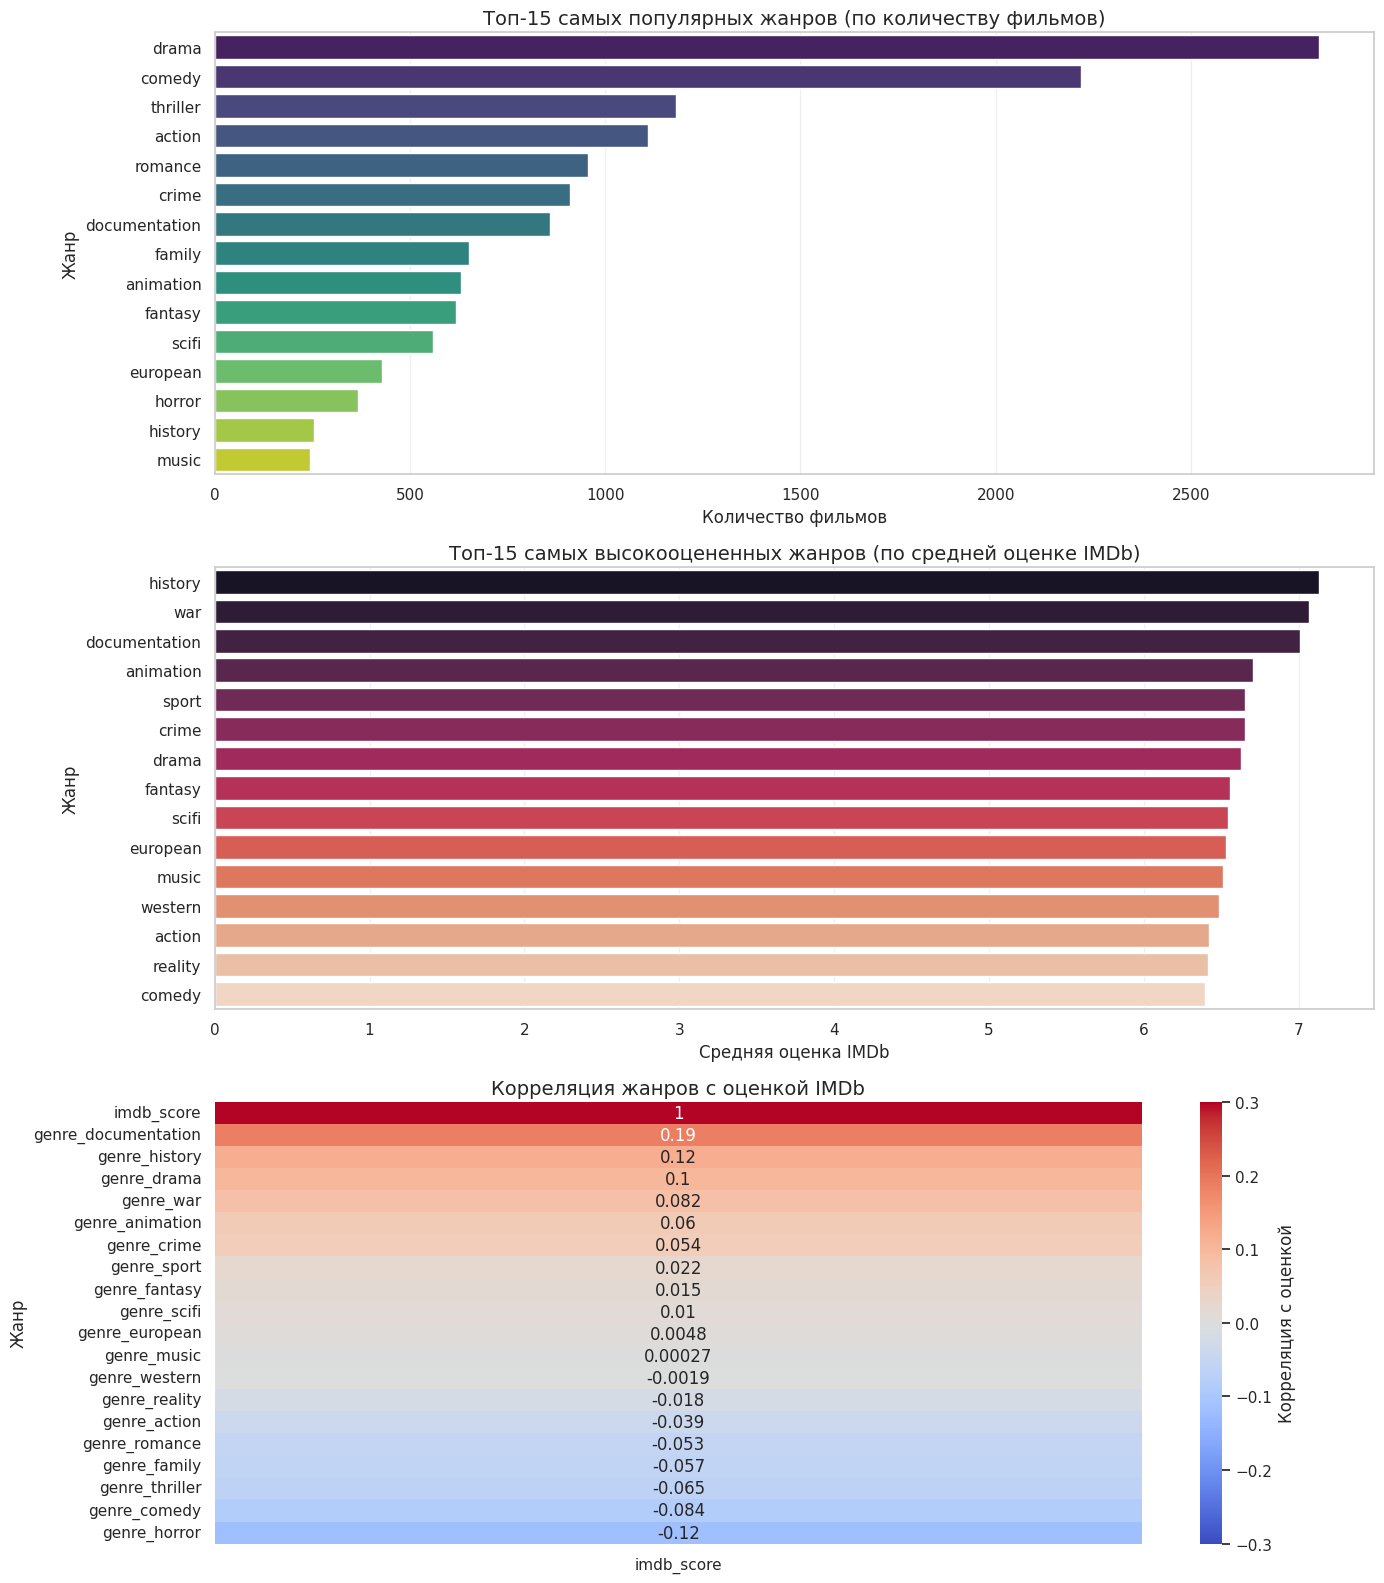

In [117]:
from ast import literal_eval


# Подготовка данных
titles_df['genres_list'] = titles_df['genres'].apply(lambda x: literal_eval(x) if isinstance(x, str) else [])
all_genres = list(set(g for genres in titles_df['genres_list'] for g in genres))

# Создаем матрицу жанров
for genre in all_genres:
    titles_df[f'genre_{genre}'] = titles_df['genres_list'].apply(lambda x: genre in x)

# 1. График популярности жанров (по количеству фильмов)
genre_counts = pd.Series({g: titles_df[f'genre_{g}'].sum() for g in all_genres}).sort_values(ascending=False)

plt.figure(figsize=(14, 16))
plt.subplot(3, 1, 1)
sns.barplot(x=genre_counts.head(15).values, y=genre_counts.head(15).index, palette='viridis')
plt.title('Топ-15 самых популярных жанров (по количеству фильмов)', fontsize=14)
plt.xlabel('Количество фильмов', fontsize=12)
plt.ylabel('Жанр', fontsize=12)
plt.grid(axis='x', alpha=0.3)

# 2. График высокооцененных жанров (по средней оценке)
genre_scores = pd.Series({
    g: titles_df[titles_df[f'genre_{g}']]['imdb_score'].mean()
    for g in all_genres
}).sort_values(ascending=False)

plt.subplot(3, 1, 2)
sns.barplot(x=genre_scores.head(15).values, y=genre_scores.head(15).index, palette='rocket')
plt.title('Топ-15 самых высокооцененных жанров (по средней оценке IMDb)', fontsize=14)
plt.xlabel('Средняя оценка IMDb', fontsize=12)
plt.ylabel('Жанр', fontsize=12)
plt.grid(axis='x', alpha=0.3)

# 3. Тепловая карта корреляции жанров с оценкой
genre_cols = [f'genre_{g}' for g in all_genres]
corr_matrix = titles_df[genre_cols + ['imdb_score']].corr()

plt.subplot(3, 1, 3)
sns.heatmap(
    corr_matrix[['imdb_score']].sort_values('imdb_score', ascending=False),
    annot=True,
    cmap='coolwarm',
    vmin=-0.3,
    vmax=0.3,
    center=0,
    cbar_kws={'label': 'Корреляция с оценкой'}
)
plt.title('Корреляция жанров с оценкой IMDb', fontsize=14)
plt.xlabel('')
plt.ylabel('Жанр', fontsize=12)
plt.yticks(rotation=0)

plt.tight_layout()
plt.show()

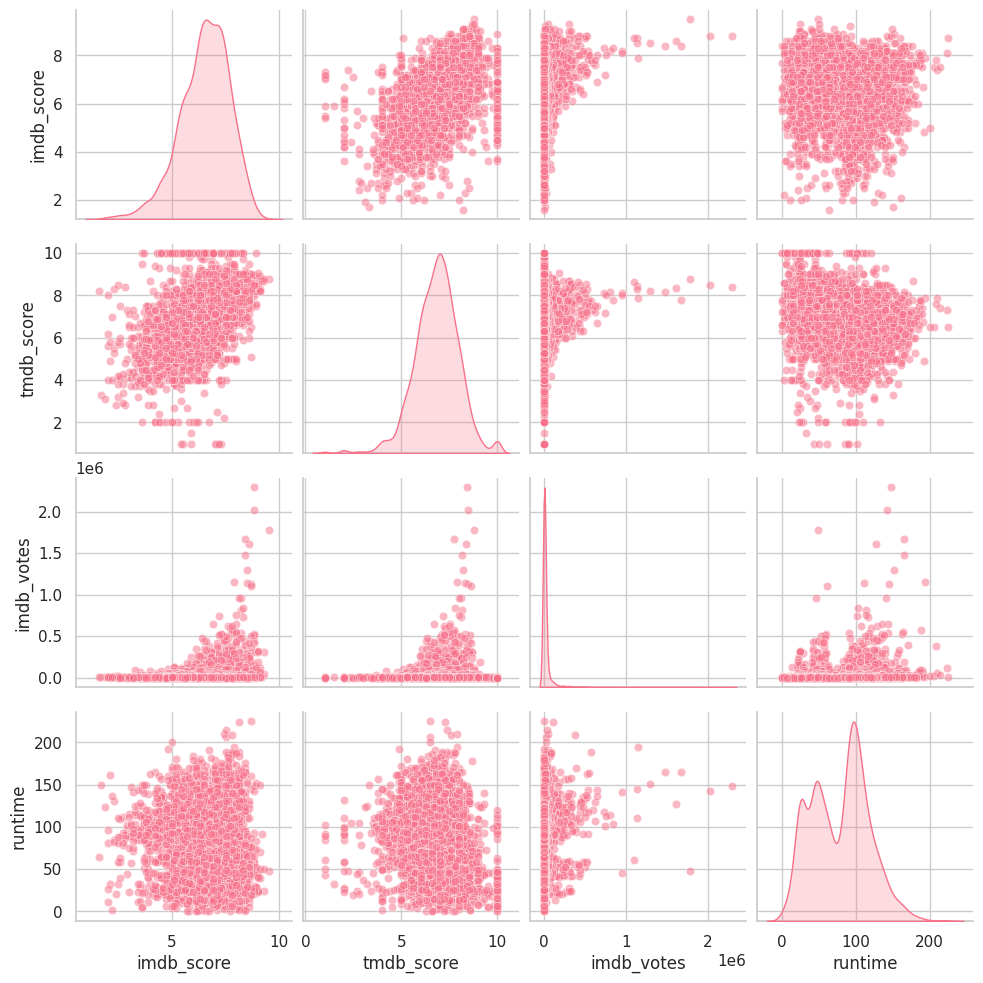

In [27]:

# Выбираем нужные числовые колонки
selected_columns = ["imdb_score", "tmdb_score", "imdb_votes", "runtime"]
pairplot_df = titles_df[selected_columns].dropna()

# Строим pairplot
sns.pairplot(pairplot_df, diag_kind="kde", plot_kws={'alpha': 0.5})

plt.show()

Для предсказания оуенки фильма (imdb_score) мы выбрали градиентный бустинг, потому что он хорошо справляется с нелинейными зависимостями, учитывает сложные взаимодействия между признаками и хорошо масштабируется.

Разделение данных:

In [118]:
from sklearn.model_selection import train_test_split

# Выбираем признаки
features = ["release_year", "runtime", "tmdb_popularity", "imdb_votes",
            "avg_actor_popularity", "num_actors", "has_top_actor"] + \
            [f"genre_{g}" for g in unique_genres] + \
            [f"country_{c}" for c in unique_countries]

X = titles_df[features]
y = titles_df["imdb_score"]

# Разделение на train/test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Размер train: {X_train.shape}, Размер test: {X_test.shape}")

Размер train: (4294, 135), Размер test: (1074, 135)


Обучение модели:

In [119]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Нормализация числовых данных
numeric_transformer = StandardScaler()
categorical_transformer = OneHotEncoder(handle_unknown="ignore")

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, [f"genre_{g}" for g in unique_genres] +
                                           [f"country_{c}" for c in unique_countries])
    ]
)

# Градиентный бустинг с GridSearch
gb = Pipeline(steps=[("preprocessor", preprocessor),
                     ("model", GradientBoostingRegressor(random_state=42))])

param_grid = {
    "model__n_estimators": [100, 200],
    "model__learning_rate": [0.05, 0.1],
    "model__max_depth": [3, 5],
}

grid_search = GridSearchCV(gb, param_grid, cv=3, scoring="r2", n_jobs=-1)
grid_search.fit(X_train, y_train)

# Лучшая модель
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

# Оценка модели
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Лучшие параметры: {grid_search.best_params_}")
print(f"MAE: {mae:.4f}")
print(f"MSE: {mse:.4f}")
print(f"R2: {r2:.4f}")

Лучшие параметры: {'model__learning_rate': 0.05, 'model__max_depth': 5, 'model__n_estimators': 200}
MAE: 0.6869
MSE: 0.8700
R2: 0.3764


Сравним градиентный бустинг с линейной регрессией:

In [120]:
from sklearn.linear_model import LinearRegression

# Обучение линейной регрессии
lr = Pipeline(steps=[("preprocessor", preprocessor),
                     ("model", LinearRegression())])

lr.fit(X_train, y_train)
y_pred_lr = lr.predict(X_test)

# Оценка линейной регрессии
mae_lr = mean_absolute_error(y_test, y_pred_lr)
mse_lr = mean_squared_error(y_test, y_pred_lr)
r2_lr = r2_score(y_test, y_pred_lr)

print(f"MAE: {mae_lr:.4f}")
print(f"MSE: {mse_lr:.4f}")
print(f"R²: {r2_lr:.4f}")

MAE: 0.8092
MSE: 1.1234
R²: 0.1947


Покажем, что линейная регрессия справляется хуже, чем градиентный бустинг:

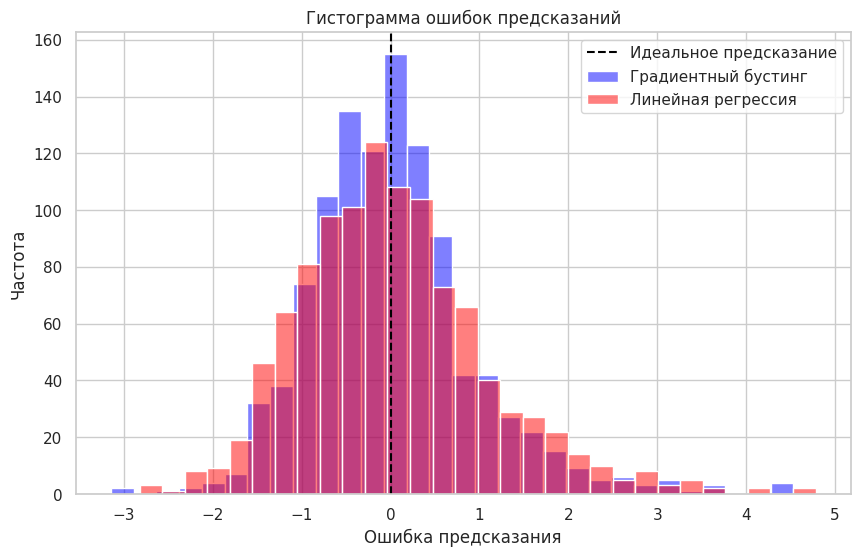

In [121]:
import seaborn as sns

# Вычисляем ошибки предсказаний
errors_gb = y_pred - y_test  # Ошибки градиентного бустинга
errors_lr = y_pred_lr - y_test  # Ошибки линейной регрессии

# Строим гистограмму ошибок
plt.figure(figsize=(10, 6))
sns.histplot(errors_gb, bins=30, color="blue", alpha=0.5, label="Градиентный бустинг")
sns.histplot(errors_lr, bins=30, color="red", alpha=0.5, label="Линейная регрессия")

plt.axvline(0, color="black", linestyle="--", label="Идеальное предсказание")
plt.xlabel("Ошибка предсказания")
plt.ylabel("Частота")
plt.title("Гистограмма ошибок предсказаний")
plt.legend()
plt.show()

Кластеризация фильмов по признакам

Цель: Мы хотим автоматически разделить фильмы на группы (кластеры), основываясь на количественных характеристиках. Это позволяет понять, какие типы фильмов существуют в датасете, какие у них общие свойства, и как можно использовать эту информацию, например, для рекомендаций или анализа рынка.

Используемые признаки: runtime — длительность фильма; release_year — год выхода; tmdb_popularity — популярность на TMDb; tmdb_score — рейтинг TMDb; imdb_score — рейтинг IMDb; imdb_votes — количество голосов на IMDb.

In [129]:
# Улучшенная обработка признаков
def enhanced_preprocessing(df):
    # Числовые признаки с более аккуратной нормализацией
    num_features = df[['runtime', 'release_year', 'tmdb_popularity',
                     'tmdb_score', 'imdb_score', 'imdb_votes']].copy()

    # Логарифмирование с защитой от нулей
    for col in ['tmdb_popularity', 'imdb_votes']:
        num_features[f'log_{col}'] = np.log1p(num_features[col].clip(lower=0.1))

    # Полиномиальные признаки для важных показателей
    num_features['score_interaction'] = num_features['imdb_score'] * num_features['tmdb_score']
    num_features['popularity_ratio'] = num_features['tmdb_popularity'] / (num_features['imdb_votes'] + 1)

    # Обработка жанров (TF-IDF вместо one-hot)
    from sklearn.feature_extraction.text import TfidfVectorizer
    tfidf = TfidfVectorizer(max_features=20)
    genre_features = tfidf.fit_transform(df['genres'].apply(lambda x: ' '.join(literal_eval(x)) if isinstance(x, str) else ''))
    genre_df = pd.DataFrame(genre_features.toarray(), columns=[f'genre_tfidf_{i}' for i in range(genre_features.shape[1])])

    # Объединение всех признаков
    final_features = pd.concat([num_features, genre_df], axis=1)

    # Удаление выбросов
    from scipy import stats
    final_features = final_features[(np.abs(stats.zscore(final_features)) < 3).all(axis=1)]

    return final_features

features = enhanced_preprocessing(titles_df)

In [130]:
from sklearn.cluster import OPTICS, SpectralClustering
from sklearn.neighbors import NearestNeighbors

# Метод локтя для определения оптимального числа кластеров
def find_optimal_clusters(data, max_k=10):
    knn = NearestNeighbors(n_neighbors=5).fit(data)
    distances, _ = knn.kneighbors(data)
    distances = np.sort(distances[:, -1])

    plt.figure(figsize=(10, 6))
    plt.plot(distances)
    plt.title('Метод локтя для определения числа кластеров')
    plt.xlabel('Точки')
    plt.ylabel('Расстояние до 5-го соседа')
    plt.grid()
    plt.show()

find_optimal_clusters(features)

# Применяем SpectralClustering с оптимальными параметрами
spectral = SpectralClustering(
    n_clusters=5,  # Подбирается по графику
    affinity='nearest_neighbors',
    n_neighbors=10,
    random_state=42
)
titles_df['cluster'] = spectral.fit_predict(features)

ValueError: Found array with 0 sample(s) (shape=(0, 29)) while a minimum of 1 is required by NearestNeighbors.

In [ ]:
from sklearn.ensemble import RandomTreesEmbedding
from sklearn.pipeline import make_pipeline

# Создаем ансамбль преобразователей
embedder = make_pipeline(
    RandomTreesEmbedding(n_estimators=100, random_state=42),
    PCA(n_components=20)
)
embedded_features = embedder.fit_transform(features)

# Кластеризация в новом пространстве
kmeans = KMeans(n_clusters=5, random_state=42)
titles_df['cluster'] = kmeans.fit_predict(embedded_features)

In [ ]:
# UMAP для визуализации (лучше чем t-SNE для кластеризации)
from umap import UMAP

reducer = UMAP(n_components=2, random_state=42)
embedding = reducer.fit_transform(features)

plt.figure(figsize=(14, 10))
sns.scatterplot(
    x=embedding[:, 0],
    y=embedding[:, 1],
    hue=titles_df['cluster'],
    palette='tab20',
    alpha=0.7,
    s=100
)
plt.title('UMAP проекция кластеров фильмов', fontsize=16)
plt.show()

# Оценка кластеров
from sklearn.metrics import davies_bouldin_score

sil_score = silhouette_score(features, titles_df['cluster'])
db_score = davies_bouldin_score(features, titles_df['cluster'])

print(f"Silhouette Score: {sil_score:.3f}")
print(f"Davies-Bouldin Score: {db_score:.3f}")  # Чем меньше, тем лучше

In [ ]:
# Анализ характеристик кластеров
cluster_stats = titles_df.groupby('cluster').agg({
    'imdb_score': ['mean', 'count'],
    'tmdb_popularity': 'mean',
    'release_year': 'median',
    'runtime': 'median'
})

# Анализ жанров в кластерах
for cluster in sorted(titles_df['cluster'].unique()):
    cluster_genres = titles_df[titles_df['cluster'] == cluster]['genres']
    top_genres = pd.Series([g for genres in cluster_genres for g in literal_eval(genres)]).value_counts().head(3)
    print(f"\nКластер {cluster}:")
    print("Характеристики:")
    display(cluster_stats.loc[cluster])
    print("Топ жанры:", ', '.join(top_genres.index))